# Crunchbase Dataset - Data Engineering and Analysis

The dataset that I'll be working with contains Crunchbase fundraising data from October 2013. 

It's a large dataset, comprising 52,000+ investment events and 18,000 companies. Because of this, my first steps will be to engineer the dataset to reduce memory usage. The goal is to reduce total memory usage to 10mb.

After that, I'll do some brief exploratory data analysis. 

#### Let's begin!

In [29]:
import pandas as pd
import numpy as np

In [32]:
import os

downloads_path = os.path.expanduser('~/Downloads')
file_path = os.path.join(downloads_path, 'crunchbase-investments.csv')

chunk_iter = pd.read_csv(file_path, chunksize=5000, encoding='Latin-1')

cb_length = []

for chunk in chunk_iter:
    cb_length.append(len(chunk))

cb_length = sum(cb_length)
print(f"This dataset contains {cb_length} rows of data")

This dataset contains 52870 rows of data


In [34]:
chunk_iter = pd.read_csv(file_path, chunksize=5000, encoding='Latin-1')

counter = 0

series_memory_fp = pd.Series(dtype = 'float64')
for chunk in chunk_iter:
    if counter == 0:
        series_memory_fp = (chunk.memory_usage(deep=True)) 
    else:
        series_memory_fp += (chunk.memory_usage(deep=True))
    counter += 1

series_memory_fp_before = series_memory_fp.drop('Index').sort_values(ascending = False)

print(f"This dataset uses {series_memory_fp_before.sum() / (1024**2)} mb of memory")

This dataset uses 50.43777942657471 mb of memory


The overarching goal is to see if there are any columns or rows of data that we can eliminate or refine, in order to make this dataset more memory-efficient. Currently, the dataset uses 50.4 mb of memory.

Let's first start with asking ourselves... 

#### "Is this column valuable to the dataset?"

One way we can ask ourselves this question is by looking at the number of missing values per column. If the majority of values are missing, we can eliminate the column as it provides no useful information.

### 1) Missing values per column
---

In [35]:
chunk_iter = pd.read_csv(file_path, chunksize=5000, encoding='Latin-1')

mv_list = []

for chunk in chunk_iter:
    if not mv_list:
        columns = chunk.columns
        print(columns.sort_values())
    mv_list.append(chunk.isnull().sum())
combined_mv_vc = pd.concat(mv_list)
unique_combined_mv_vc = combined_mv_vc.groupby(combined_mv_vc.index).sum()

print("\nNumber of missing values")
print("--------------------------------")
unique_combined_mv_vc

Index(['company_category_code', 'company_city', 'company_country_code',
       'company_name', 'company_permalink', 'company_region',
       'company_state_code', 'funded_at', 'funded_month', 'funded_quarter',
       'funded_year', 'funding_round_type', 'investor_category_code',
       'investor_city', 'investor_country_code', 'investor_name',
       'investor_permalink', 'investor_region', 'investor_state_code',
       'raised_amount_usd'],
      dtype='object')

Number of missing values
--------------------------------


company_category_code       643
company_city                533
company_country_code          1
company_name                  1
company_permalink             1
company_region                1
company_state_code          492
funded_at                     3
funded_month                  3
funded_quarter                3
funded_year                   3
funding_round_type            3
investor_category_code    50427
investor_city             12480
investor_country_code     12001
investor_name                 2
investor_permalink            2
investor_region               2
investor_state_code       16809
raised_amount_usd          3599
dtype: int64

Given that are entire dataset is 52870 rows, we can note that the vast majority of values for *`investor_category_code`* are missing (50427) so we can drop this column.

Next, let's look at how much memory usage each column takes up.

### 2) Memory usage per column
---

In [42]:
drop_cols = []

drop_cols.append('investor_category_code')

In [43]:
chunk_iter = pd.read_csv(file_path, chunksize=5000, encoding='Latin-1')

counter = 0

series_memory_fp = pd.Series(dtype = 'float64')
for chunk in chunk_iter:
    if counter == 0:
        series_memory_fp = (chunk.memory_usage(deep=True) / (1024**2))
    else:
        series_memory_fp += (chunk.memory_usage(deep=True) / (1024**2))
    counter += 1

print(f"Memory usage (mb) per column")
print("----------------------------------")

series_memory_fp_before = series_memory_fp.drop('Index').sort_values(ascending = False)
series_memory_fp_before

Memory usage (mb) per column
----------------------------------


investor_permalink        4.346470
company_permalink         3.466450
investor_name             3.330423
company_name              3.021200
funded_at                 2.974748
company_city              2.944174
company_category_code     2.864159
company_region            2.850144
funding_round_type        2.849360
investor_region           2.835450
funded_quarter            2.823494
funded_month              2.823494
company_country_code      2.621864
company_state_code        2.562549
investor_city             2.442515
investor_country_code     2.212849
investor_state_code       2.086753
investor_category_code    0.574951
funded_year               0.403366
raised_amount_usd         0.403366
dtype: float64

Columns with highest memory usage are `company_permalink` and `investor_permalink` which are URLs. For analytical purposes, these URLs are likely to not serve any value so we can **drop** them. 

Let's drop these columns. Additionally, let's also drop `funded_month`, `funded_quarter`, `funded_year` as these values are encapsulated by `funded_at` already.

In [44]:
drop_cols.extend([
    'investor_permalink',
    'company_permalink',
    'funded_month',
    'funded_quarter',
    'funded_year'])

keep_cols = chunk.columns.drop(drop_cols)

keep_cols.tolist()

['company_name',
 'company_category_code',
 'company_country_code',
 'company_state_code',
 'company_region',
 'company_city',
 'investor_name',
 'investor_country_code',
 'investor_state_code',
 'investor_region',
 'investor_city',
 'funding_round_type',
 'funded_at',
 'raised_amount_usd']

We've removed columns that aren't valuable to our dataset analysis. Next, let's see if we can change the datatypes of our columns to something more efficient.

### 3) Datatypes of columns
---

In [51]:
col_types = {}
chunk_iter = pd.read_csv(file_path, chunksize=5000, encoding='Latin-1',usecols = keep_cols)

for chunk in chunk_iter:
    for col in chunk.columns:
        if col not in col_types:
            col_types[col] = [str(chunk.dtypes[col])]
        else:
            col_types[col].append(str(chunk.dtypes[col]))

uniq_col_types = {}
for k,v in col_types.items():
    uniq_col_types[k] = set(col_types[k])

print("Current datatype(s) of each column")
print("--------------------------------------------\n")
uniq_col_types

Current datatype(s) of each column
--------------------------------------------



{'company_name': {'object'},
 'company_category_code': {'object'},
 'company_country_code': {'object'},
 'company_state_code': {'object'},
 'company_region': {'object'},
 'company_city': {'object'},
 'investor_name': {'object'},
 'investor_country_code': {'float64', 'object'},
 'investor_state_code': {'float64', 'object'},
 'investor_region': {'object'},
 'investor_city': {'float64', 'object'},
 'funding_round_type': {'object'},
 'funded_at': {'object'},
 'raised_amount_usd': {'float64'}}

In [98]:
chunk.head()

,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type,funded_at,raised_amount_usd
50000,NuORDER,fashion,USA,CA,Los Angeles,West Hollywood,Mortimer Singer,NaN,NaN,unknown,NaN,series-a,2012-10-01,3060000.00
50001,ChaCha,advertising,USA,IN,Indianapolis,Carmel,Morton Meyerson,NaN,NaN,unknown,NaN,series-b,2007-10-01,12000000.00
50002,Binfire,software,USA,FL,Bocat Raton,Bocat Raton,Moshe Ariel,NaN,NaN,unknown,NaN,angel,2008-04-18,500000.00
50003,Binfire,software,USA,FL,Bocat Raton,Bocat Raton,Moshe Ariel,NaN,NaN,unknown,NaN,angel,2010-01-01,750000.00
50004,Unified Color,software,USA,CA,SF Bay,South San Frnacisco,Mr. Andrew Oung,NaN,NaN,unknown,NaN,angel,2010-01-01,NaN


One way to save memory is to convert `object` datatypes into `category` datatypes. 

It seems like we have many good potential candidates for categorical values, like "company_state_code" or "company_country_code". Let's compare the number of unique values per column. For columns with a low number of unique values, we can convert the respective data into a categorical variable.

In [99]:
unique_values = {}

chunk_iter = pd.read_csv(file_path, chunksize=5000, encoding='Latin-1',usecols = keep_cols)

for chunk in chunk_iter:
    for col in chunk.columns:
        if col not in unique_values:
            unique_values[col] = set()
        unique_values[col].update(chunk[col].unique())

for col,unique_vals in unique_values.items():
    print(f"Column: {col}, Unique Values: {len(unique_vals)}")

Column: company_name, Unique Values: 11574
Column: company_category_code, Unique Values: 44
Column: company_country_code, Unique Values: 3
Column: company_state_code, Unique Values: 51
Column: company_region, Unique Values: 547
Column: company_city, Unique Values: 1230
Column: investor_name, Unique Values: 10466
Column: investor_country_code, Unique Values: 75
Column: investor_state_code, Unique Values: 53
Column: investor_region, Unique Values: 586
Column: investor_city, Unique Values: 993
Column: funding_round_type, Unique Values: 10
Column: funded_at, Unique Values: 2809
Column: raised_amount_usd, Unique Values: 1469


As a rule of thumb, we can say that, if less than 5% of a variable's total values are unique, it is a suitable candidate for categorical data types. 

Given that most the number of total values in each column is 36,000 - 52,000 (depending on the number of missing values), we're looking for a number of unique values less than 1,800 - 2,600.

Aside from `company_name`, `investor_name` and `funded_at` - all variables satisfy this condition. 

In [54]:
col_types = {
    'company_category_code': 'category',
    'company_country_code': 'category',
    'company_state_code': 'category',
    'funding_round_type': 'category',
    'investor_state_code': 'category',
    'investor_country_code': 'category',
    'investor_city': 'category',
    'company_city': 'category',
    'investor_region': 'category',
    'company_region': 'category'}

We can also see that `raised_amount_usd` has a datatype `float64`. Let's see if we can use `float32` which would reduce memory usage for `raised_amount_usd` by half.

In [101]:
min_val = float('inf')
max_val = float('-inf')

chunk_iter = pd.read_csv(file_path, chunksize=5000, encoding='Latin-1', usecols=['raised_amount_usd'])

for chunk in chunk_iter:
    non_null = chunk['raised_amount_usd'].dropna()
    if not non_null.empty:
        min_val = min(min_val, non_null.min())
        max_val = max(max_val, non_null.max())

print(f"Min: {min_val}, Max: {max_val}")

Min: 1000.0, Max: 3200000000.0


The maximum value of `raised_amount_usd` is 3,200,000,000 which is small enough for `float32`. (The biggest value stored by float32 is 3.4028235 × 10³⁸!)

However, `float32` can only store 7 significant figures for each value. Our largest value of `raised_amount_usd` is 10 significant figures.

Let's see if converting to `float32` will lead to any rounding errors.

In [70]:
chunk_iter = pd.read_csv(file_path,chunksize=5000,encoding='Latin-1')

inaccurate_all = []

for chunk in chunk_iter:
    original = chunk['raised_amount_usd'].dropna()
    float32_vals = original.astype(np.float32)

    diffs = original - float32_vals

    mask = diffs != 0
    if mask.any():
        inaccurate = pd.DataFrame({
            'raised_amount_usd': original[mask],
            'float32_val': float32_vals[mask],
            'difference': diffs[mask]
        })
        inaccurate_all.append(inaccurate)

if inaccurate_all:
    result = pd.concat(inaccurate_all)

    count_diff = (result['difference'].abs() > 0).sum()
    print(f"Number of values with precision loss: {count_diff}\n\n")

    print("Top 10 values of 'raised_amount_usd' by size of difference")
    print(result.reindex(result['difference'].abs().sort_values(ascending=False).index).head(10))
    
else:
    print("No precision loss found when converting to float32.")

Number of values with precision loss: 61


Top 10 values of 'raised_amount_usd' by size of difference
       raised_amount_usd  float32_val  difference
28406        198730677.0  198730672.0         5.0
10035         35632090.0   35632088.0         2.0
5629          47167166.0   47167168.0        -2.0
14192         47628902.0   47628904.0        -2.0
2418          54660614.0   54660616.0        -2.0
17636         35632090.0   35632088.0         2.0
19674         54660614.0   54660616.0        -2.0
21901         57000002.0   57000000.0         2.0
39331         54660614.0   54660616.0        -2.0
35203         48218802.0   48218800.0         2.0


Our analysis suggests that there will be rounding errors if we convert data from `float64` into `float32` - specifically, there will be 61 values that will have rounding errors. However, as the table shows, this difference is minimal

In [102]:
def get_chunk_iter(file_path, chunksize=5000, encoding='Latin-1', usecols=None, dtype=None, parse_dates=None, drop_missing_raised_amount=False):

    raw_iter = pd.read_csv(file_path, 
                           chunksize=chunksize, 
                           encoding=encoding, 
                           usecols=usecols, 
                           dtype=dtype, 
                           parse_dates=parse_dates,
                          low_memory = False)

    if not drop_missing_raised_amount:
        return raw_iter
    else:
        def filtered_iter():
            for chunk in raw_iter:
                chunk = chunk.dropna(subset=['raised_amount_usd'])
                chunk['raised_amount_usd'] = chunk['raised_amount_usd'].astype('int64')
                yield chunk
        return filtered_iter()

In [103]:
# col_types = {
#     'company_category_code': 'category',
#     'company_country_code': 'category',
#     'company_state_code': 'category',
#     'funding_round_type': 'category',
#     'investor_state_code': 'category',
#     'investor_country_code': 'category',
#     'investor_city': 'category',
#     'company_city': 'category',
#     'investor_region': 'category',
#     'company_region': 'category'}

chunk_iter = get_chunk_iter(file_path, chunksize=5000, encoding='Latin-1',usecols = keep_cols,dtype = col_types, parse_dates = ['funded_at'], drop_missing_raised_amount = True)

In [104]:
investor_cities = set()

chunk_iter = get_chunk_iter(
    file_path,
    chunksize=5000,
    encoding='Latin-1',
    usecols=keep_cols,
    dtype=col_types,
    parse_dates=['funded_at'],
    drop_missing_raised_amount=True
)

for chunk in chunk_iter:
    cities = chunk['investor_city'].dropna().unique()
    investor_cities.update(cities)

print(f"Found {len(investor_cities)} unique investor cities.")
print(sorted(investor_cities))

Found 955 unique investor cities.
['ABERDEEN', 'ADELAIDE', 'ALBURY', 'AUSTIN', 'Aalborg', 'Abbotsford', 'Abu Dhabi', 'Accra', 'Addison', 'Adelaide', 'Agoura Hills', 'Aichi', 'Akron', 'Alamo', 'Albany', 'Alberta', 'Albuquerque', 'Alexandria', 'Aliso Viejo', 'Allentown', 'Alpharetta', 'Alphen aan den Rijn', 'Alpine', 'Altadena', 'American Falls', 'Ames', 'Amesbury', 'Amherst', 'Amman', 'Amsterdam', 'Anchorage', 'Andover', 'Ann Arbor', 'Annapolis', 'Antwerpen', 'Arlington', 'Armonk', 'Arnold', 'Arva', 'Asheville', 'Aspen', 'Athens', 'Atherton', 'Atlanta', 'Atlanta, GA 30348', 'Atsugi-City', 'Auburn', 'Auckland', 'Auckland Central', 'Audubon', 'Austin', 'Avon', 'BOSTON', 'Baar-Zug', 'Bad Homburg', 'Bagsvaerd', 'Bainbridge Island', 'Bala Cynwyd', 'Bala Cynwyd,', 'Baltimore', 'Bangalore', 'Barcelona', 'Basel', 'Basking Ridge', 'Bath', 'Baton Rouge', 'Baytown', 'Beachwood', 'Beaverton', 'Bedford', 'Beijing', 'Beirut Central District', 'Belfast', 'Bellevue', 'Bend', 'Bensheim-Auerbach', 'Berke

In [105]:
def find_duplicates_across_chunks(chunk_iter, subset_cols):
    seen = set()
    duplicates = []

    for chunk in chunk_iter:
        # Create a key for each row based on the subset columns
        chunk['dupe_key'] = list(zip(*(chunk[col] for col in subset_cols)))

        # Mark rows that have already been seen
        mask_duplicate = chunk['dupe_key'].isin(seen)
        duplicates.append(chunk[mask_duplicate])

        # Update seen set with current chunk keys
        seen.update(chunk['dupe_key'])

    # Combine duplicates from all chunks
    if duplicates:
        return pd.concat(duplicates, ignore_index=True)
    else:
        return pd.DataFrame()

In [106]:
subset_cols = ['company_name', 'investor_name', 'funded_at', 'raised_amount_usd']

chunk_iter = get_chunk_iter(file_path, chunksize=5000, encoding='Latin-1',usecols = keep_cols,dtype = col_types, parse_dates = ['funded_at'], drop_missing_raised_amount = True)

duplicates = find_duplicates_across_chunks(chunk_iter, subset_cols)

print(f"Found {len(duplicates)} duplicate rows")
print(duplicates.head())

Found 0 duplicate rows
Empty DataFrame
Columns: [company_name, company_category_code, company_country_code, company_state_code, company_region, company_city, investor_name, investor_country_code, investor_state_code, investor_region, investor_city, funding_round_type, funded_at, raised_amount_usd, dupe_key]
Index: []


There are no duplicates across chunks! So we only need to be concerned with duplicates within chunks.

In [107]:
chunk_iter = get_chunk_iter(file_path, chunksize=5000, encoding='Latin-1',usecols = keep_cols,dtype = col_types, parse_dates = ['funded_at'], drop_missing_raised_amount = True)

duplicates = []

for chunk in chunk_iter:
    dupes = chunk[chunk.duplicated(subset = subset_cols, keep = False)]
    duplicates.append(dupes)

if duplicates:
    duplicates = pd.concat(duplicates, ignore_index = True)

print(f"Found {len(duplicates)} duplicate rows")
print(duplicates.head())

Found 275 duplicate rows
                        company_name company_category_code  \
0                              Row44       network_hosting   
1                              Row44       network_hosting   
2  Massachusetts Clean Energy Center             cleantech   
3  Massachusetts Clean Energy Center             cleantech   
4                         SeeControl             analytics   

  company_country_code company_state_code company_region      company_city  \
0                  USA                 CA    Los Angeles  Westlake Village   
1                  USA                 CA    Los Angeles  Westlake Village   
2                  USA                 MA         Boston            Boston   
3                  USA                 MA         Boston            Boston   
4                  USA                 CA         SF Bay      Redwood City   

                      investor_name investor_country_code investor_state_code  \
0        Advanced Inflight Alliance                 

In [108]:
chunk_iter = get_chunk_iter(file_path, chunksize=5000, encoding='Latin-1',
                            usecols=keep_cols, dtype=col_types,
                            parse_dates=['funded_at'], drop_missing_raised_amount=True)

for i, chunk in enumerate(chunk_iter):
    chunk = chunk.drop_duplicates(subset=subset_cols, keep='first')
    mode = 'w' if i == 0 else 'a'
    header = i == 0
    chunk.to_csv("cleaned_output.csv", mode=mode, header=header, index=False)

downloads_path = os.path.expanduser('/Users/dominiclong/Documents/2025 Applications/DataQuest')
file_path = os.path.join(downloads_path, 'cleaned_output.csv')

In [109]:
chunk_iter = get_chunk_iter(file_path, chunksize=5000, encoding='Latin-1',usecols = keep_cols,dtype = col_types, parse_dates = ['funded_at'], drop_missing_raised_amount = True)

cb_length = []

for chunk in chunk_iter:
    cb_length.append(len(chunk))

cb_length = sum(cb_length)
cb_length

49133

In [110]:
df = pd.read_csv(file_path)

print(df['raised_amount_usd'].isna().sum())

0


In [111]:
chunk_iter = get_chunk_iter(file_path, chunksize=5000, encoding='Latin-1',usecols = keep_cols,dtype = col_types, parse_dates = ['funded_at'], drop_missing_raised_amount = True)

counter = 0

series_memory_fp = pd.Series(dtype = 'float64')
for chunk in chunk_iter:
    if counter == 0:
        series_memory_fp = chunk.memory_usage(deep=True)
    else:
        series_memory_fp += chunk.memory_usage(deep=True)
    counter += 1

series_memory_fp_after = series_memory_fp.drop('Index').sort_values()
series_memory_fp_after

series_memory_fp_after.sum() / (1024*1024)

np.float64(8.250224113464355)

In [112]:
df = pd.DataFrame({
    'Before': series_memory_fp_before,
    'After': series_memory_fp_after,
    'Difference': series_memory_fp_after - series_memory_fp_before})

df.sort_values('Difference')

,Before,After,Difference
funding_round_type,2987771,56705.00,-2931066.00
company_category_code,3003288,83330.00,-2919958.00
investor_region,2973185,197740.00,-2775445.00
company_region,2988593,256901.00,-2731692.00
funded_at,3119249,393064.00,-2726185.00
company_country_code,2749224,49653.00,-2699571.00
company_state_code,2687027,82905.00,-2604122.00
company_city,3087190,529775.00,-2557415.00
investor_city,2561163,262619.00,-2298544.00
investor_country_code,2320340,73293.00,-2247047.00


In [113]:
print(f"Total Memory (Before): {series_memory_fp_before.sum() / (1024*1024)}")
print(f"Total Memory (After): {series_memory_fp_after.sum() / (1024*1024)}")

Total Memory (Before): 50.43777942657471
Total Memory (After): 8.250224113464355


Total Memory Usage has dropped dramatically!

In [155]:
import sqlite3

conn = sqlite3.connect('crunchbaseTest.db')
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS investments;")
conn.commit()  

chunk_iter = get_chunk_iter(file_path, chunksize=5000, encoding='Latin-1', usecols = keep_cols, dtype = col_types, parse_dates = ['funded_at'], drop_missing_raised_amount = True)

for chunk in chunk_iter:
    chunk['raised_amount_usd'] = pd.to_numeric(chunk['raised_amount_usd'], errors='coerce').astype('int64')
    chunk.to_sql("investments", conn, if_exists = "append", index = False)

cursor.execute("SELECT name from sqlite_master WHERE type = 'table';")
tables = cursor.fetchall()

if tables:
    print("Tables found in the database", [t[0] for t in tables])
else:
    print("No tables found in the database.")

Tables found in the database ['investments']


In [156]:
cursor.execute("SELECT * FROM investments LIMIT 5;")
print(cursor.fetchall())

[('AdverCar', 'advertising', 'USA', 'CA', 'SF Bay', 'San Francisco', '1-800-FLOWERS.COM', 'USA', 'NY', 'New York', 'New York', 'series-a', '2012-10-30 00:00:00', 2000000), ('LaunchGram', 'news', 'USA', 'CA', 'SF Bay', 'Mountain View', '10Xelerator', 'USA', 'OH', 'Columbus', 'Columbus', 'other', '2012-01-23 00:00:00', 20000), ('uTaP', 'messaging', 'USA', None, 'United States - Other', None, '10Xelerator', 'USA', 'OH', 'Columbus', 'Columbus', 'other', '2012-01-01 00:00:00', 20000), ('ZoopShop', 'software', 'USA', 'OH', 'Columbus', 'columbus', '10Xelerator', 'USA', 'OH', 'Columbus', 'Columbus', 'angel', '2012-02-15 00:00:00', 20000), ('eFuneral', 'web', 'USA', 'OH', 'Cleveland', 'Cleveland', '10Xelerator', 'USA', 'OH', 'Columbus', 'Columbus', 'other', '2011-09-08 00:00:00', 20000)]


In [157]:
cursor.execute("PRAGMA table_info(investments);")
columns_info = cursor.fetchall()

column_names = [col[1] for col in columns_info]
print("Column names:", column_names)

Column names: ['company_name', 'company_category_code', 'company_country_code', 'company_state_code', 'company_region', 'company_city', 'investor_name', 'investor_country_code', 'investor_state_code', 'investor_region', 'investor_city', 'funding_round_type', 'funded_at', 'raised_amount_usd']


In [166]:
cursor.execute("SELECT COUNT(*) FROM investments")

total_rows = cursor.fetchone()[0]
ten_percent = int(total_rows * 0.10)
one_percent = int(total_rows * 0.01)

print(ten_percent, one_percent)

cursor.execute(f"""WITH top_1pct_funding AS (SELECT company_name, raised_amount_usd FROM investments ORDER BY raised_amount_usd DESC limit {one_percent})
                    SELECT ROUND((sum(raised_amount_usd) *100.0 / (SELECT sum(raised_amount_usd) FROM investments)),2) as fund_raised_1pct FROM top_1pct_funding""")

print(cursor.fetchall())

4913 491
[(19.3,)]


In [159]:
cursor.execute(f"""SELECT count(*) FROM investments WHERE raised_amount_usd IS NULL""")

print(cursor.fetchall())

[(0,)]


In [167]:
cursor.execute(f"""WITH top_10pct_funding as (SELECT company_name, raised_amount_usd FROM investments ORDER BY raised_amount_usd DESC limit {ten_percent})
                    SELECT ROUND((sum(raised_amount_usd) * 100.0 / (SELECT sum(raised_amount_usd) FROM investments)),2) as fund_raised_10pct FROM top_10pct_funding;""")

print(cursor.fetchall())

[(49.86,)]


In [168]:
cursor.execute(f"""WITH bottom_10pct_funding as (SELECT company_name, raised_amount_usd FROM investments ORDER BY raised_amount_usd ASC limit {ten_percent})
                    SELECT ROUND((sum(raised_amount_usd) *100.0 / (SELECT sum(raised_amount_usd) FROM investments)),2) as fund_raised_bottom_10pct FROM bottom_10pct_funding;""")

print(cursor.fetchall())

[(0.26,)]


In [171]:
cursor.execute(f"""WITH bottom_1pct_funding as (SELECT company_name, raised_amount_usd FROM investments ORDER BY raised_amount_usd ASC limit {one_percent})
                    SELECT ROUND((sum(raised_amount_usd)*100.0 / (SELECT sum(raised_amount_usd) FROM investments)),5) as fund_raised_bottom_1pct FROM bottom_1pct_funding;""")

print(cursor.fetchall())

[(0.00132,)]


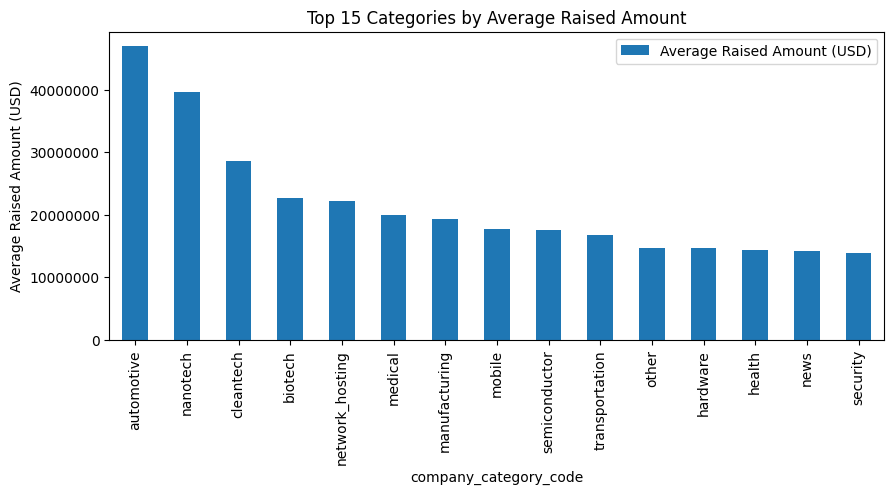

In [163]:
pd.set_option('display.float_format', '{:.2f}'.format)

df = pd.read_sql("""
                SELECT company_category_code, AVG(raised_amount_usd) AS "Average Raised Amount (USD)"
                FROM investments
                GROUP BY company_category_code
                ORDER BY AVG(raised_amount_usd) DESC;""",conn)

df = df.set_index('company_category_code')

top_n = 15
ax = df.head(top_n).plot(kind = 'bar', figsize = (10,4))
ax.set_ylabel('Average Raised Amount (USD)')
ax.set_title(f'Top {top_n} Categories by Average Raised Amount')
ax.ticklabel_format(style = 'plain', axis = 'y')

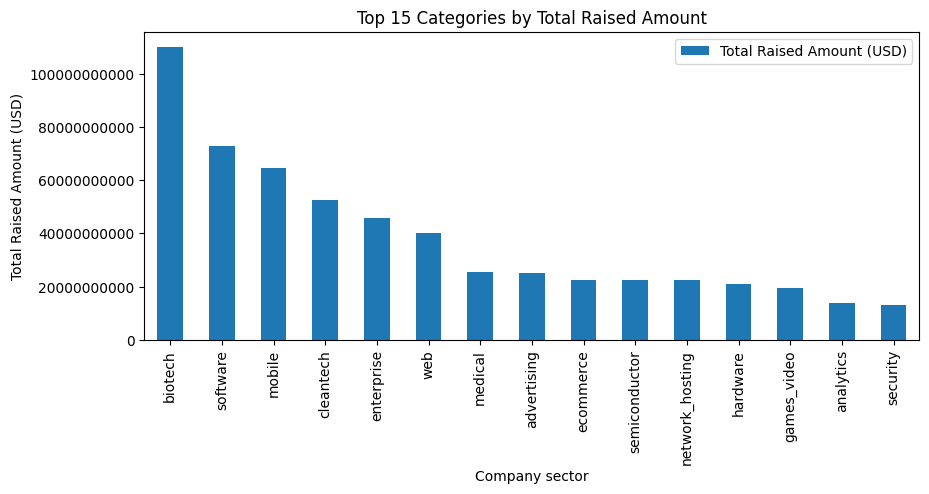

In [174]:
pd.set_option('display.float_format', '{:2f}'.format)

df = pd.read_sql("""
                SELECT company_category_code, SUM(raised_amount_usd) AS "Total Raised Amount (USD)" 
                FROM investments
                GROUP BY company_category_code
                ORDER BY SUM(raised_amount_usd) DESC;""", conn)

df = df.set_index('company_category_code')

top_n = 15

ax = df.head(top_n).plot(kind = 'bar', figsize = (10,4))
ax.set_ylabel('Total Raised Amount (USD)')
ax.set_xlabel('Company sector')
ax.set_title(f'Top {top_n} Categories by Total Raised Amount')
ax.ticklabel_format(style = 'plain', axis = 'y')

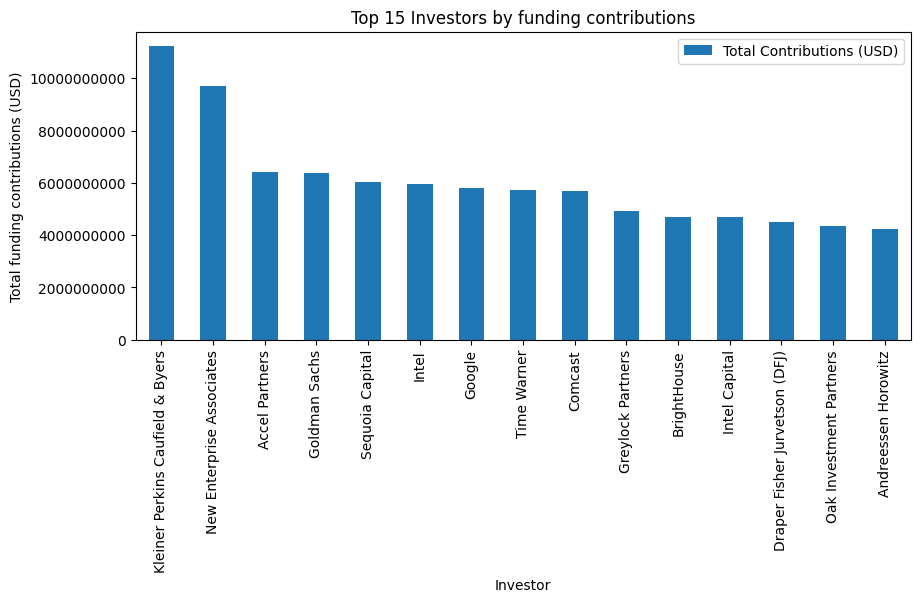

In [176]:
pd.set_option('display.float_format', '{:2f}'.format)

df = pd.read_sql("""
                SELECT investor_name, SUM(raised_amount_usd) AS "Total Contributions (USD)" 
                FROM investments
                GROUP BY investor_name
                ORDER BY SUM(raised_amount_usd) DESC;""", conn)

df = df.set_index('investor_name')

top_n = 15

ax = df.head(top_n).plot(kind = 'bar', figsize = (10,4))
ax.set_ylabel('Total funding contributions (USD)')
ax.set_xlabel('Investor')
ax.set_title(f'Top {top_n} Investors by funding contributions')
ax.ticklabel_format(style = 'plain', axis = 'y')

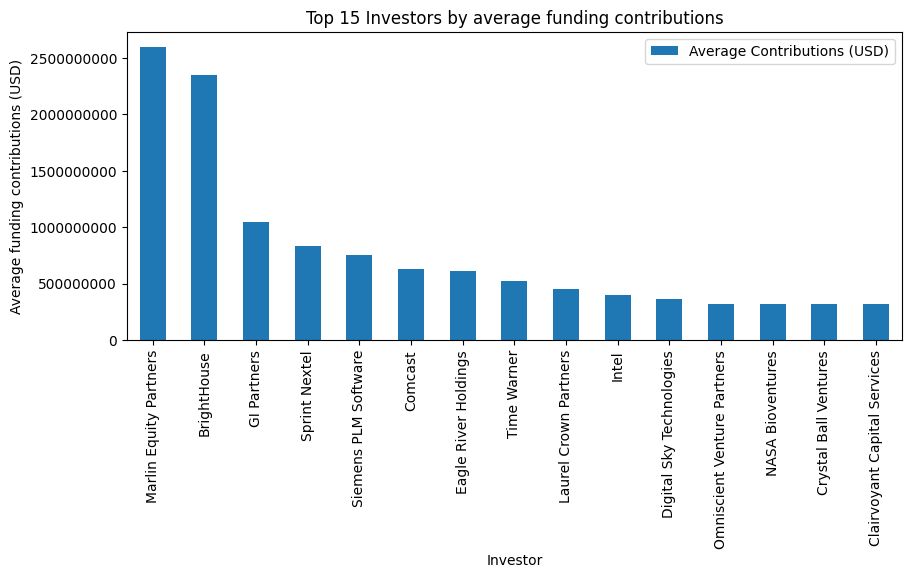

In [179]:
pd.set_option('display.float_format', '{:2f}'.format)

df = pd.read_sql("""
                SELECT investor_name, AVG(raised_amount_usd) AS "Average Contributions (USD)" 
                FROM investments
                GROUP BY investor_name
                ORDER BY AVG(raised_amount_usd) DESC;""", conn)

df = df.set_index('investor_name')

top_n = 15

ax = df.head(top_n).plot(kind = 'bar', figsize = (10,4))
ax.set_ylabel('Average funding contributions (USD)')
ax.set_xlabel('Investor')
ax.set_title(f'Top {top_n} Investors by average funding contributions')
ax.ticklabel_format(style = 'plain', axis = 'y')

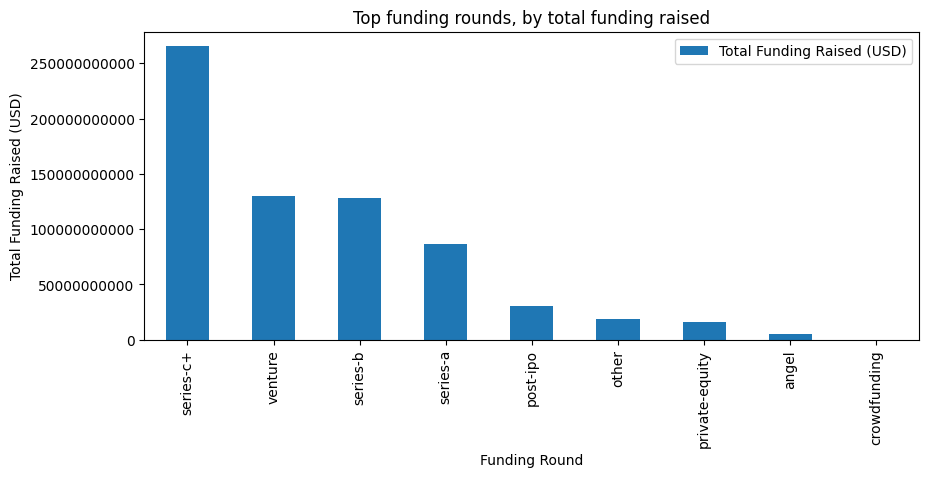

In [177]:
pd.set_option('display.float_format', '{:2f}'.format)

df = pd.read_sql("""
                SELECT funding_round_type, SUM(raised_amount_usd) AS "Total Funding Raised (USD)" 
                FROM investments
                GROUP BY funding_round_type
                ORDER BY SUM(raised_amount_usd) DESC;""", conn)

df = df.set_index('funding_round_type')

top_n = 15

ax = df.head(top_n).plot(kind = 'bar', figsize = (10,4))
ax.set_ylabel('Total Funding Raised (USD)')
ax.set_xlabel('Funding Round')
ax.set_title(f'Top funding rounds, by total funding raised')
ax.ticklabel_format(style = 'plain', axis = 'y')

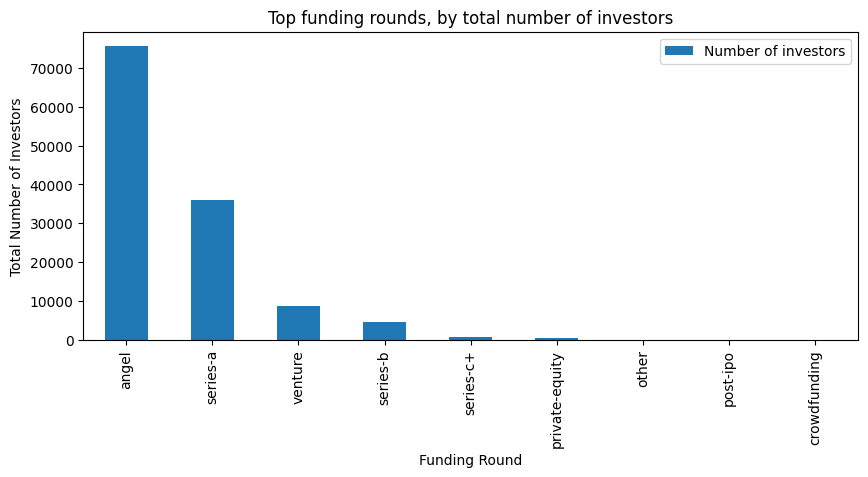

In [178]:
pd.set_option('display.float_format', '{:2f}'.format)

df = pd.read_sql("""
                SELECT funding_round_type, SUM(investor_name) AS "Number of investors" 
                FROM investments
                GROUP BY funding_round_type
                ORDER BY SUM(investor_name) DESC;""", conn)

df = df.set_index('funding_round_type')

top_n = 15

ax = df.head(top_n).plot(kind = 'bar', figsize = (10,4))
ax.set_ylabel('Total Number of Investors')
ax.set_xlabel('Funding Round')
ax.set_title(f'Top funding rounds, by total number of investors')
ax.ticklabel_format(style = 'plain', axis = 'y')

Can we convert raised_amount_usd to a more precise data type? DONE
Can we drop duplicates, incorrect values?

What proportion of the total amount of funds did the top 10% raise? What about the top 1%?

Compare these values to the proportions of the bottom 10% and bottom 1%?

Which category of companies attracted the most investments?

Which investor contributed the most money across all startups?

Which investors contribted the most money per startup?

Which funding round was the most popular? Which was the least popular?